# Decision Trees

Decision trees are a highly interpretable<sup>1</sup>, easy-to-overfit type of model. They are best for modeling datasets where the relationship between the features and the target can be represented well with "if-this-then-this" type of statements. They will be the basis for one of the most popular ensemble methods: random forests.

A decision tree is a machine learning model that works by *partitioning* our sample space in a hierarchical way.

How do we partition the space? The key idea is that some attributes provide more *information* than others when trying to make a decision.

<sup>1</sup>_"Highly interpretable" matters if you need to be able to explain how the model decided to classify a given record in a given way. Simpler models tend to be more interpretable._


### Example:

![example titanic decision tree](images/titanic_tree.png)

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# This data is a processed version of recent Austin Animal Shelter data
df = pd.read_csv("data/processed_shelter.csv")

In [3]:
df.head()

,is_dog,age_in_days,is_female,adoption
0,0,122,0,0
1,1,742,0,0
2,1,742,0,0
3,1,742,1,0
4,1,744,1,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   is_dog       937 non-null    int64
 1   age_in_days  937 non-null    int64
 2   is_female    937 non-null    int64
 3   adoption     937 non-null    int64
dtypes: int64(4)
memory usage: 29.4 KB


In [5]:
df.describe()

,is_dog,age_in_days,is_female,adoption
count,937.000000,937.000000,937.000000,937.000000
mean,0.499466,629.173959,0.498399,0.683031
std,0.500267,986.180273,0.500264,0.465544
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,80.000000,0.000000,0.000000
50%,0.000000,200.000000,0.000000,1.000000
75%,1.000000,745.000000,1.000000,1.000000
max,1.000000,6727.000000,1.000000,1.000000


## Decision Trees by Hand

Without using any Python tools, we could try to develop a decision tree to determine the outcome for a given animal. Let's start with a simplified view of 10 samples from our dataset.

In [6]:
example_sample = df.sample(10, random_state=20)
example_sample

,is_dog,age_in_days,is_female,adoption
592,0,90,0,1
62,0,84,0,1
366,0,1115,0,0
403,0,307,1,0
874,0,100,1,1
443,1,69,0,1
58,1,428,1,1
820,1,282,0,1
116,0,367,0,0
533,1,311,1,0


We want to predict whether `adoption` is a 1 or a 0. Can we perfectly represent this with "if-then" statements?

#### Split on Dogs/Non-Dogs

Let's start with "if the animal is a dog" to split into 2 groups

In [7]:
dogs = example_sample[example_sample["is_dog"]==1]
dogs

,is_dog,age_in_days,is_female,adoption
443,1,69,0,1
58,1,428,1,1
820,1,282,0,1
533,1,311,1,0


In [8]:
non_dogs = example_sample[example_sample["is_dog"]==0]
non_dogs

,is_dog,age_in_days,is_female,adoption
592,0,90,0,1
62,0,84,0,1
366,0,1115,0,0
403,0,307,1,0
874,0,100,1,1
116,0,367,0,0


#### Assessment of Decision Tree After One Split

Initially we had 10 animals, 60% of which were adopted, 40% of which weren't

Now we have `dogs`, of which 3/4 were adopted, and `non_dogs`, of which 3/6 were adopted. If we guessed "adoption" for all dogs, and "not adoption" for all non-dogs, we would be correct the majority of the time (6/10)

Let's do another split.

#### Split on Age

Let's split each of the existing groups into 2 groups based on whether the animals are more than or less than 300 days old.

In [9]:
old_dogs = dogs[dogs["age_in_days"]>300]
old_dogs

,is_dog,age_in_days,is_female,adoption
58,1,428,1,1
533,1,311,1,0


In [10]:
young_dogs = dogs[dogs["age_in_days"]<=300]
young_dogs

,is_dog,age_in_days,is_female,adoption
443,1,69,0,1
820,1,282,0,1


In [11]:
old_non_dogs = non_dogs[non_dogs["age_in_days"]>300]
old_non_dogs

,is_dog,age_in_days,is_female,adoption
366,0,1115,0,0
403,0,307,1,0
116,0,367,0,0


In [12]:
young_non_dogs = non_dogs[non_dogs["age_in_days"]<=300]
young_non_dogs

,is_dog,age_in_days,is_female,adoption
592,0,90,0,1
62,0,84,0,1
874,0,100,1,1


#### Assessment of Decision Tree After Two Splits

Now we have four categories, based on two splits:

```
if (dog):
  --> if (age>300):   NOT ADOPTED (1/2 adopted)
  --> if (age<=300):  ADOPTED     (2/2 adopted)
if (not dog):
  --> if (age>300):   NOT ADOPTED (0/3 adopted)
  --> if (age<=300):  ADOPTED     (3/3 adopted)
```

So if we guessed the majority class for each category each time (randomly choosing a tie-breaker), we would guess:

 - All old dogs are not adopted
 - All young dogs are adopted
 - All old non-dogs are not adopted
 - All young non-dogs are adopted

...which would mean we got 9 right, 1 wrong on the dataset overall, i.e. an 90% accuracy.  Pretty good for a pretty simple model! Definitely a lot easier than hand-calculating a logistic regression or kNN model.

#### Reflection

If we wanted to keep going, to be able to get to 100% accuracy, we could further slice by `age_in_days` to get the right answers for those last one. But rather than get into that, let's think about what we just did, and whether it was optimal.

Was splitting on dog/non-dog the right choice for our first split?

But how would my partition be *best* split? And how do I really know that the second split is better than the first? Can I do better than intuition here?  

## Decision Trees at a High Level

### High level of how the Decision Tree algorithm works

 - Select the best attribute using Attribute Selection Measures (Gini/Entropy) to split the records
 -  Make that attribute a decision node and break the dataset into smaller subsets
 -  Starts tree building by repeating this process recursively for each child until one of these conditions will match:
    - You have reached a pure split: the leaf has only 1 class
    - There are no more remaining attributes to split on
    - There are no more instances

### Important Terminology related to Decision Trees
Let’s look at the basic terminologies used with Decision trees:

- **Root Node:** It represents entire population or sample, aka the root of the tree (which is typically, and unintuitively, at the top of the representation of most decision trees)
- **Decision Node:** When a sub-node splits into further sub-nodes, then it is called a Decision node
- **Leaf / Terminal Node:** Nodes with no children (no further splits) are called Leaf or Terminal nodes
- **Pruning:** When we reduce the size of decision trees by removing nodes (opposite of Splitting), the process is called pruning
- **Branch / Sub-Tree:** A sub section of decision tree is called branch or sub-tree
- **Parent and Child Node:** A node, which is divided into sub-nodes is called parent node of sub-nodes, whereas sub-nodes are the child of parent nodes


![](images/decision_leaf.webp)

### Entropy/Information Gain and Gini

The goal is to have our ultimate categories be fully "ordered" (for a binary dependent variable, we'd have the 1's in one group and the 0's in the other). So one way to assess the value of a split is to measure how *disordered* our groups are, and there is a notion of *entropy* that measures precisely this.

The entropy of the whole dataset is given by:

$\large E = -\Sigma^n_i p_i\log_2(p_i)$,

where $p_i$ is the probability of belonging to the $i$th group, where $n$ is the number of groups (i.e. target values).

**Entropy will always be between 0 and 1. The closer to 1, the more disordered your group.**

![](images/Entropy_mapped.png)

To repeat, in the present case we have only two groups of interest: adoption and no adoption.

#### Entropy for Entire Sample (10 Pets)

6 out of 10 were adopted and 4 out of 10 were not adopted, so **these are the relevant probabilities** for our calculation of entropy.

So our entropy for the sample above is:

$-4/10*\log_2(4/10) -6/10*\log_2(6/10)$.

Let's use the ``numpy's`` `log2()` function to calculate this:

In [13]:
(-.4) * np.log2(.4) - (.6) * np.log2(.6)

0.9709505944546686

That is a very disordered collection! Which makes sense, since it's 40/60 adopted/not adopted 

#### Entropy for Dog/Non-Dog Split

To calculate the entropy of a *split*, we're going to want to calculate the entropy of each of the groups made by the split, and then calculate a weighted average of those groups' entropies––weighted, that is, by the size of the groups. Let's calculate the entropy of the split produced by our "is our animal a dog" question:

**Group 1 (not a dog):** 3 adoptions, 3 not adoptions (6 total not dogs)

$E_{g1} = -\frac{3}{6} * \log_2\left(\frac{3}{6}\right) - \frac{3}{6} * \log_2\left(\frac{3}{6}\right)$. 

**Group 2 (dogs):** 3 adoptions, 1 not adoption (4 total dogs)

$E_{g2} = -\frac{3}{4} * \log_2\left(\frac{3}{4}\right) - \frac{1}{4} * \log_2\left(\frac{1}{4}\right)$.


In [15]:
# Group one (not dogs)
Egnd = (-3/6)*np.log2(3/6) - (3/6)*np.log2(3/6)
print(Egnd)

# Group two (dogs)
Egd = (-3/4)*np.log2(3/4) - (1/4)*np.log2(1/4)
print(Egd)

1.0
0.8112781244591328


Now weight those by the probability of each group, and sum them, to find the entropy of the split:

In [16]:
# Weighted sum
pgnd = (6/10) * Egnd
pgd = (4/10) * Egd

E_split_d = pgnd + pgd
E_split_d

0.9245112497836532

So, we have made some improvement from the .97 entropy of the original, now we are getting 0.92

In [17]:
example_sample

,is_dog,age_in_days,is_female,adoption
592,0,90,0,1
62,0,84,0,1
366,0,1115,0,0
403,0,307,1,0
874,0,100,1,1
443,1,69,0,1
58,1,428,1,1
820,1,282,0,1
116,0,367,0,0
533,1,311,1,0


In [21]:
example_sample[example_sample['is_female'] == 0]

,is_dog,age_in_days,is_female,adoption
592,0,90,0,1
62,0,84,0,1
366,0,1115,0,0
443,1,69,0,1
820,1,282,0,1
116,0,367,0,0


#### Entropy for Male/Female Split

Compare that to the male/female question (if we asked that first):

**Group 1 (female):** 2 adoptions, 2 not adoptions (4 total females)

$E_{g1} = -\frac{2}{4} * \log_2\left(\frac{2}{4}\right) - \frac{2}{4} * \log_2\left(\frac{2}{4}\right)$. 

**Group 2 (male):** 4 adoptions, 2 not adoption (6 total males)

$E_{g2} = -\frac{4}{6} * \log_2\left(\frac{4}{6}\right) - \frac{2}{6} * \log_2\left(\frac{2}{6}\right)$.

In [22]:
# Group one (females) 
Egf =  - (2/4)*np.log2(2/4) - (2/4)*np.log2(2/4)
print(Egf)

# Group two (males)
Egm = - (4/6)*np.log2(4/6) - (2/6)*np.log2(2/6) 
print(Egm)

1.0
0.9182958340544896


In [23]:
# Weighted sum
pgm = Egf * 4/10
pgf = Egm * 6/10

E_split_f = pgm + pgf
E_split_f

0.9509775004326938

This entropy is 0.95, whereas the other split had 0.92

#### Choosing the Best Information Gain

For a given split, the **information gain** is simply the entropy of the parent group less the entropy of the split.

In [24]:
total_entropy_sample = (-.4) * np.log2(.4) - (.6) * np.log2(.6)

# Information gain, dog or cat
ig_d = total_entropy_sample - E_split_d
print(f"Information gain dog/cat: {ig_d}")

# Information gain, male or female
ig_f = total_entropy_sample - E_split_f
print(f"Information gain male/female: {ig_f}")

Information gain dog/cat: 0.0464393446710154
Information gain male/female: 0.01997309402197478


For a given parent, then, we maximize our model's performance by *minimizing* the split's entropy (which maximizes our information gain!).

What we'd like to do then is:

1. to look at the entropies of all possible splits, and
2. to choose the split with the lowest entropy.

In practice there are far too many splits for it to be practical for a person to calculate all these different entropies ...

... but we can make computers do these calculations for us! (thanks sklearn)

### Gini Impurity

An alternative metric to entropy comes from the work of Corrado Gini. The Gini Impurity is defined as:

$\large G = 1 - \Sigma_ip_i^2$, or, equivalently, $\large G = \Sigma_ip_i(1-p_i)$.

where, again, $p_i$ is the probability of belonging to the $i$th group.

**Gini Impurity will always be between 0 and 0.5. The closer to 0.5, the more disordered your group.**

### Impurity Metric Caveat


As found in *Introduction to Data Mining* by Tan et. al:

> "Studies have shown that the choice of impurity measure has little effect on the performance of decision tree induction algorithms. This is because many impurity measures are quite consistent with each other [...]. Indeed, the strategy used to prune the tree has a greater impact on the final tree than the choice of impurity measure."

(We'll get into more detail on "pruning" and why you want to do it in the "Issues with Decision Trees" section)

## Decision Trees in SciKit-Learn

Having gone into all of that math detail... we actually won't need to implement that ourselves, in practice. Instead, we can use Sklearn - specifically, the `DecisionTreeClassifier` (since we're classifying our data).

(There is also a `DecisionTreeRegressor` which doesn't use entropy or Gini to measure the utility of the split, and instead uses a technique to reduce the standard deviation, since this works on data with a continuous target variable. More details [here](https://www.saedsayad.com/decision_tree_reg.htm) if you are curious.)

In [25]:
# More imports
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

#### Data Preparation

In [26]:
X = df.drop(['adoption'], axis=1)
y = df.adoption

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=.2)
X_train.head()

,is_dog,age_in_days,is_female
5,1,746,1
54,1,372,0
275,1,4052,1
884,1,925,1
344,0,97,0


#### Creating, Fitting, and Scoring the Model

In [27]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

y_hat_test = dt.predict(X_test)

print(f'Training Score: {dt.score(X_train, y_train)}')
print(f'Test Score: {dt.score(X_test, y_test)}')

Training Score: 0.9626168224299065
Test Score: 0.7659574468085106


#### Additional Model Evaluation Metrics

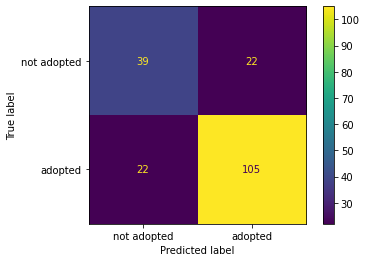

In [28]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, recall_score, precision_score

plot_confusion_matrix(dt, X_test, y_test, display_labels=['not adopted', 'adopted']);

In [29]:
print(f'Test Accuracy Score: {accuracy_score(y_test, y_hat_test)}')
print('-------------------')
print(f'Test Precision Score: {precision_score(y_test, y_hat_test)}')
print('-------------------')
print(f'Test Recall Score: {recall_score(y_test, y_hat_test)}')
print('-------------------')
print(f'Test F1_score: {f1_score(y_test, y_hat_test)}')
print('-------------------')
print(f'Test ROC-AUC Score: {roc_auc_score(y_test, y_hat_test)}')

Test Accuracy Score: 0.7659574468085106
-------------------
Test Precision Score: 0.8267716535433071
-------------------
Test Recall Score: 0.8267716535433071
-------------------
Test F1_score: 0.8267716535433071
-------------------
Test ROC-AUC Score: 0.7330579579191945


#### Visualizations

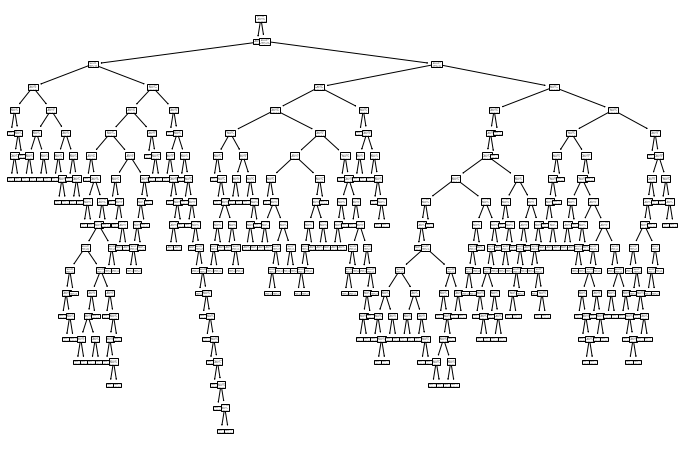

In [30]:
from sklearn.tree import plot_tree

fig, ax = plt.subplots(figsize=(12, 8))
plot_tree(dt, ax=ax);

## The Biggest Issue with Decision Trees?

## Decision trees are SUPER prone to overfitting!

The image above is a good visual to represent an overfit tree.  Let's look at the accuracy.

In [31]:
dt.score(X_train, y_train)

0.9626168224299065

Let's compare it to the test set:

In [32]:
dt.score(X_test, y_test)

0.7659574468085106

That's a big drop-off!

### Issue: Bias-Variance with Decision Trees

The CART algorithm will repeatedly partition data into smaller and smaller subsets until those final subsets are homogeneous in terms of the outcome variable. In practice this often means that the final subsets (known as the leaves of the tree) each consist of only one or a few data points. 

This results in low-bias, high variance trees.


### Issue: Decision trees are very sensitive to training data

Let's fit two trees based on two different samples of the data, and look at the difference.

In [33]:
dt_samp1 = DecisionTreeClassifier(max_depth=5)

X_tr_sample_1 = X_train.sample(100, random_state=1)
y_tr_sample_1 = y_train[X_tr_sample_1.index]

dt_samp1.fit(X_tr_sample_1, y_tr_sample_1)

DecisionTreeClassifier(max_depth=5)

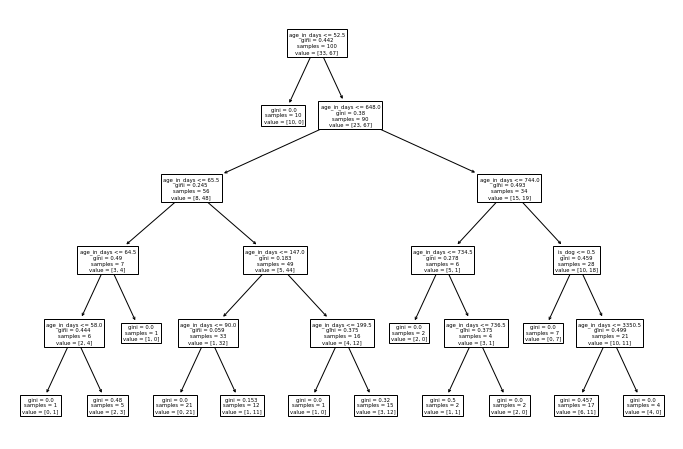

In [34]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_tree(dt_samp1, ax=ax, feature_names=X_train.columns);

In [35]:
dt_samp2 = DecisionTreeClassifier(max_depth=5)

X_tr_sample_2 = X_train.sample(90, random_state=42)
y_tr_sample_2 = y_train[X_tr_sample_2.index]

dt_samp2.fit(X_tr_sample_2, y_tr_sample_2)

DecisionTreeClassifier(max_depth=5)

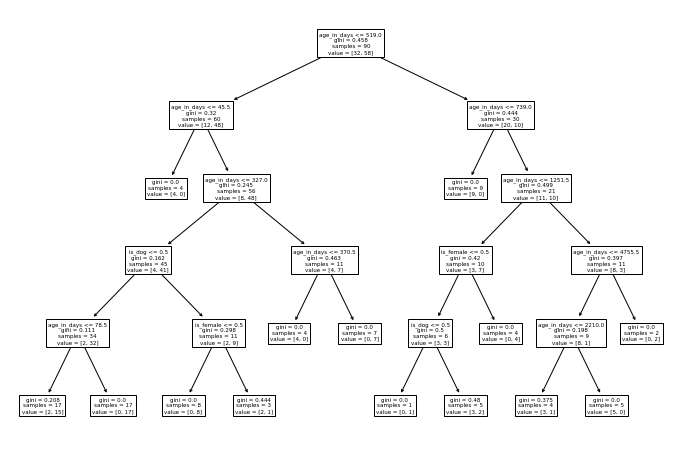

In [36]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_tree(dt_samp2, ax=ax, feature_names=X_train.columns);

### Issue: Greediness

Decision trees will always split on the features with the most advantageous split. 

Take the above example.  The algorithm is almost exclusively using the `age_in_days` feature, potentially obscuring more-valuable information in `is_female` or `is_dog` 

We will see how to overcome greediness - making these models care about other features that can be useful - with Random Forests (Topic 30).

### Solution: Stopping Criterion - Pruning Parameters

The recursive binary splitting procedure described above needs to know when to stop splitting as it works its way down the tree with the training data.

`min_samples_leaf`: The most common stopping procedure is to use a minimum count on the number of training instances assigned to each leaf node. If the count is less than some minimum then the split is not accepted and the node is taken as a final leaf node.

`max_leaf_nodes` : Reduce the number of leaf nodes

`max_depth` : Reduce the depth of the tree to build a generalized tree.

`min_impurity_split` : A node will split if its impurity is above the threshold, otherwise it is a leaf.


Typically these _hyper-parameters_ are set after verification on test data (or based on cross validation results)

Let's try limiting the depth (by default the limit is `None`, i.e. unlimited depth):

In [37]:
# Start with a max depth of 10
dt = DecisionTreeClassifier(max_depth=10)

dt.fit(X_train, y_train)

print(f'Train Accuracy: {dt.score(X_train, y_train)}')
print(f'Test Accuracy: {dt.score(X_test, y_test)}')

Train Accuracy: 0.9092122830440588
Test Accuracy: 0.8031914893617021


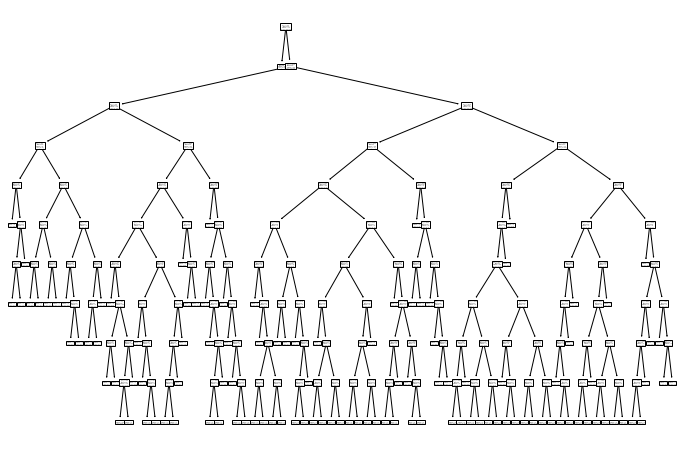

In [38]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_tree(dt, ax=ax);

In [39]:
# Now a max depth of 5
dt = DecisionTreeClassifier(max_depth=5)

dt.fit(X_train, y_train)

print(f'Train Accuracy: {dt.score(X_train, y_train)}')
print(f'Test Accuracy: {dt.score(X_test, y_test)}')

Train Accuracy: 0.8170894526034713
Test Accuracy: 0.7712765957446809


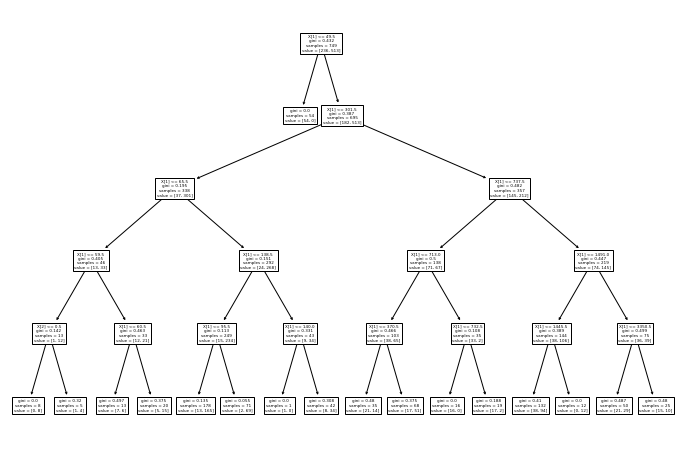

In [40]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_tree(dt, ax=ax);

In [43]:
# Now a max depth of 1
dt = DecisionTreeClassifier(max_depth=1, criterion='entropy')

dt.fit(X_train, y_train)

print(f'Train Accuracy: {dt.score(X_train, y_train)}')
print(f'Test Accuracy: {dt.score(X_test, y_test)}')

Train Accuracy: 0.7570093457943925
Test Accuracy: 0.75


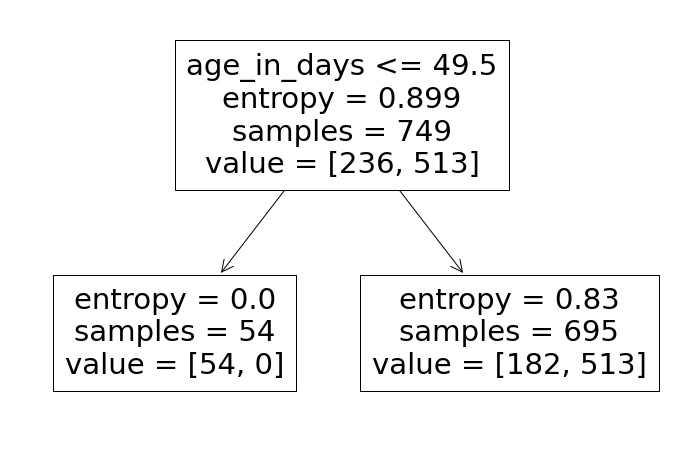

In [44]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_tree(dt, ax=ax, 
          feature_names=X_train.columns); #adding this since we can read it now!

Let's try limiting minimum samples per leaf (by default the limit is `1`, i.e. a leaf node can have as few as 1 sample in it):

In [45]:
# Start with 5
dt = DecisionTreeClassifier(min_samples_leaf=5)

dt.fit(X_train, y_train)

print(f'Train Accuracy: {dt.score(X_train, y_train)}')
print(f'Test Accuracy: {dt.score(X_test, y_test)}')

Train Accuracy: 0.8718291054739653
Test Accuracy: 0.7872340425531915


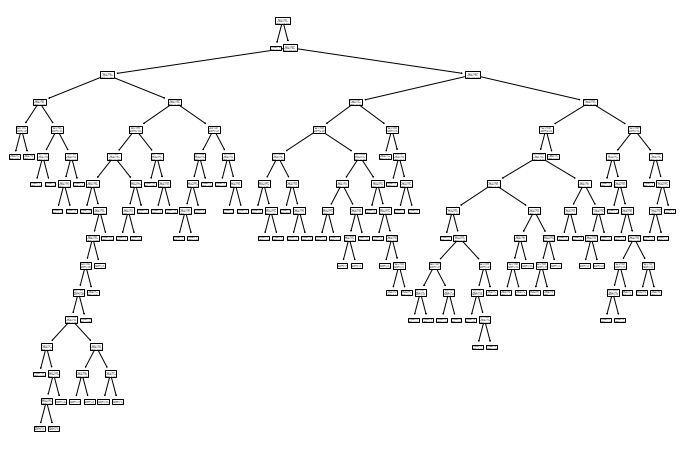

In [46]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_tree(dt, ax=ax);

In [47]:
# Then 10
dt = DecisionTreeClassifier(min_samples_leaf=10)

dt.fit(X_train, y_train)

print(f'Train Accuracy: {dt.score(X_train, y_train)}')
print(f'Test Accuracy: {dt.score(X_test, y_test)}')

Train Accuracy: 0.8384512683578104
Test Accuracy: 0.8085106382978723


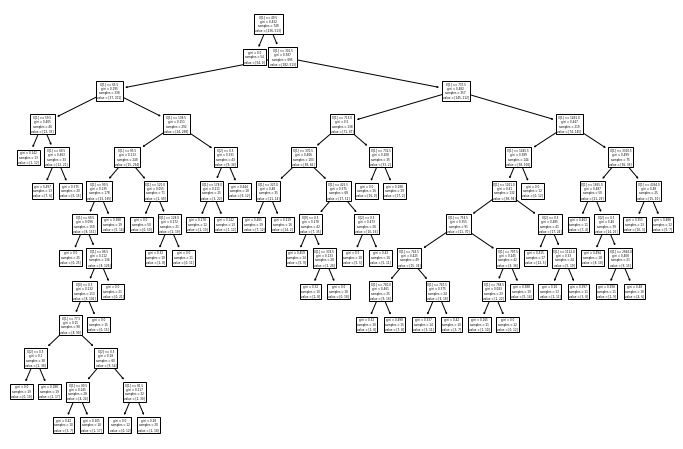

In [48]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_tree(dt, ax=ax);

![](https://miro.medium.com/max/1136/1*3MDxpY_pIMs0yb4dc55KpQ.jpeg)

We played around with some hyperparameters in the above trees, and they can have a huge impact! We'll explore using a Grid Search in Topic 30 as a way to programmatically and systematically decide which hyperparameters are best.

Now, last but not least:

## Feature Importances

The fitted tree has an attribute called `dt.feature_importances_`. What does this mean? Roughly, the importance (or "Gini importance") of a feature is a sort of weighted average of the impurity decrease at internal nodes that make use of the feature. The weighting comes from the number of samples that depend on the relevant nodes.

> The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance. [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.feature_importances_)

In [49]:
dt = DecisionTreeClassifier(max_depth=8)
dt.fit(X_train, y_train)

print(f'Train Accuracy: {dt.score(X_train, y_train)}')
print(f'Test Accuracy: {dt.score(X_test, y_test)}')
print('*' * 10)

for fi, feature in zip(dt.feature_importances_, X_train.columns):
    print(f'{feature}: {fi}')

Train Accuracy: 0.8731642189586115
Test Accuracy: 0.8031914893617021
**********
is_dog: 0.05892213373203728
age_in_days: 0.9014234067590096
is_female: 0.039654459508953244


More on feature importances [here](https://towardsdatascience.com/the-mathematics-of-decision-trees-random-forest-and-feature-importance-in-scikit-learn-and-spark-f2861df67e3)

# Conclusions

Decision Trees are a 'white box' type of ML algorithm. It shares internal decision-making logic, which is not available in the black box type of algorithms such as Neural Networks. The training time is faster compared to neural networks, too. 

Note that decision trees are non-parametric and do not depend upon probability distribution assumptions. Decision trees can handle high dimensional data (many columns) with good accuracy - but need to be pruned to be effective!

#### Pros
- Decision trees are easy to interpret and visualize
- They can easily capture non-linear patterns
- They require little data preprocessing from the user - for example, there is no need to normalize/scale columns
- They can be used for feature engineering such as predicting missing values, suitable for variable selection
- They have no assumptions about distributions because of the non-parametric nature of the algorithm

#### Cons
- Sensitive to noisy data - easily overfits to noisy data
- Small variations (or variance) in data can result in a completely different decision tree. This can be reduced by bagging and boosting algorithms (still to come in this phase).
- Decision trees are biased with imbalanced datasets, so it is recommended that you balance out the dataset before creating the decision tree.